# Sentiment Analysis Training

## Import dependencies

In [1]:
# System
import re
import multiprocessing

# Data manipulation
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
# ML

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

from joblib import dump, load

In [3]:
# NLP
from wordcloud import WordCloud

from xgboost import XGBClassifier

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Prep nltk library
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load & inspect

In [4]:
# Load data
file_path = '../../data/slava_ukraini_tweets.csv'
raw_tweets_df = pd.read_csv(file_path)
raw_tweets_df.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1498446801376002051,Rob Smith 🇨🇦 🇺🇦,"Ontario, Canada","Proud Canadian 🇨🇦, ❤️ baseball ⚾️, ❤️ history,...",2013-02-18 18:05:01,395,1898,4137,False,2022-02-28 23:55:31,@kiraincongress Photos of rally in support of ...,NaN,Twitter for iPhone,0,0,False
1,1498446755947499524,Frags,Chicago,ay yo video games\nMarried To My Best Friend @...,2013-05-18 16:53:43,10523,269,3051,False,2022-02-28 23:55:21,#Russia propaganda on #Twitter attempting to d...,"['Russia', 'Twitter', 'Ukraine']",Twitter for iPhone,0,1,False
2,1498446700096245760,Mark Malahosky 🇺🇦,"Webster, NY",Pharmacist practicing at a Federally Qualified...,2015-07-14 12:38:43,184,164,38434,False,2022-02-28 23:55:07,@1Arnold_Friend @MaryEmBern @13WHAM Putin lack...,['SlavaUkraini'],Twitter for iPhone,0,1,False
3,1498446601710448647,oz,"Hlavní město Praha, Česká repu",foodandfilms,2013-07-21 11:38:47,17,93,7907,False,2022-02-28 23:54:44,"@profgalloway Dear prof, I have been following...",NaN,Twitter for Android,0,1,False
4,1498446536820224000,Sydfish 🇺🇦🇺🇦🇺🇦🇺🇦,"California, USA",Soccer mom with a punk rock heart!!!!🛑NO LISTS...,2008-12-20 22:41:51,9136,8070,167748,False,2022-02-28 23:54:28,I’ve done more than 100 in St. Petersburg. \n\...,NaN,Twitter for iPhone,0,0,False
5,1498446504528207872,Kwolikowa 🇺🇦💪🇵🇱,The East Bay,working cat mom. lover of freedom. hater of di...,2011-12-20 02:32:24,31,295,635,False,2022-02-28 23:54:21,@lesiavasylenko Speak your truth!! #SlavaUkraini,['SlavaUkraini'],Twitter for iPhone,0,1,False
6,1498446476493701123,Kas,"Guadalajara, Jalisco",Looking through the glass of rainbow,2009-12-14 22:55:37,675,1269,28334,False,2022-02-28 23:54:14,Heroes\n#SlavaUkraini https://t.co/gl7n6LgEWF,['SlavaUkraini'],Twitter for iPad,0,0,False
7,1498446442406588419,Jinx Spidox ➡️ Gdakon,"Glasgow, Scotland","Railway Electrician, Lanky Wuff, Skoda driver,...",2012-08-23 14:06:58,758,774,40027,False,2022-02-28 23:54:06,#SlavaUkraini good night #Ukraine keep up the ...,"['SlavaUkraini', 'Ukraine']",Twitter Web App,0,4,False
8,1498446410227851265,Jackie Blue 🇺🇸 🇨🇦 🇺🇦 🌻,🇺🇸 Wrong Side of the 49th,"Well, now on to the next emergency. (And more ...",2022-02-02 05:14:11,254,221,3880,False,2022-02-28 23:53:58,@anagin40 @NATO It sadly took Ukraine being a ...,NaN,Twitter Web App,0,2,False
9,1498446402267095040,Lydia B. 🗝🐉,NaN,it was his hat mr krabs. he was number one!\n\...,2013-10-04 20:52:31,208,915,4401,False,2022-02-28 23:53:56,@MrBeast @AndreaRussett @RosannaPansino @Jacks...,NaN,Twitter Web App,0,1,False


In [5]:
# Get general overview
raw_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30468 entries, 0 to 30467
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30468 non-null  int64 
 1   user_name         30468 non-null  object
 2   user_location     20963 non-null  object
 3   user_description  27257 non-null  object
 4   user_created      30468 non-null  object
 5   user_followers    30468 non-null  int64 
 6   user_friends      30468 non-null  int64 
 7   user_favourites   30468 non-null  int64 
 8   user_verified     30468 non-null  bool  
 9   date              30468 non-null  object
 10  text              30468 non-null  object
 11  hashtags          19869 non-null  object
 12  source            30468 non-null  object
 13  retweets          30468 non-null  int64 
 14  favorites         30468 non-null  int64 
 15  is_retweet        30468 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 3.3+ MB


In [6]:
# Get unique values
raw_tweets_df.nunique()

id                  30468
user_name           12256
user_location        4691
user_description    10907
user_created        12010
user_followers       4638
user_friends         4600
user_favourites     12741
user_verified           2
date                29564
text                30414
hashtags             7154
source                 41
retweets              139
favorites             301
is_retweet              1
dtype: int64

In [7]:
# Check locations (may imply language)
raw_tweets_df['user_location'].value_counts()

United States                    406
Bracknell UK                     351
London                           216
Canada                           213
London, England                  197
                                ... 
iPhone: 33.580254,-117.198929      1
Albany, NY                         1
Jersey City, NJ                    1
A State Of Rarefied Delirium       1
Western MA                         1
Name: user_location, Length: 4691, dtype: int64

## Cleaning

In [8]:
# Select relevant columns
col_rename_map = {
    'date': 'date',
    'user_name': 'username',
    'user_description': 'description',
    'user_location': 'location',
    'text': 'tweet',
    'hashtags': 'hashtags'
}

tweets_df = raw_tweets_df[list(col_rename_map.keys())].rename(columns=col_rename_map)

tweets_df.shape

(30468, 6)

In [9]:
# Check duplicate tweets
tweets_df['tweet'].duplicated(keep='first').sum()

54

In [10]:
# Drop duplicate tweets
tweets_df = tweets_df.drop_duplicates(subset='tweet', keep='first')
tweets_df.shape

(30414, 6)

In [11]:
# Initialize Lemmatizer and stopwords
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [12]:
# Define cleaning functions

def cleanTweet(tweet):

    tweet = tweet.lower()
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet)
    tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] )
    
    lem_stopwords = [lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) 
                     if x not in stop_words]
    tweet = ' '.join(lem_stopwords)
    
    return [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(tweet) 
             if x not in stop_words]


def cleanHashtags(hashtags):

    if hashtags:
        hashtags = hashtags.lower()
        hashtags = re.sub('\$[a-zA-Z0-9]*', ' ', hashtags)
        hashtags = re.sub('[^a-zA-Z]', ' ', hashtags)
        hashtags=hashtags.strip() 
    return hashtags

In [13]:
# Clean tweets
tweets_df['clean_tweet'] = tweets_df['tweet'].apply(lambda x: cleanTweet(x))
tweets_df['cleaned_tweet'] = tweets_df['clean_tweet'].apply(lambda x:' '.join(x))

In [14]:
# Clean hashtags
tweets_df["hashtags"] = tweets_df["hashtags"].astype(str)
tweets_df["hashtags"] = tweets_df["hashtags"].apply(lambda x: cleanHashtags(x))

In [15]:
tweets_df.head()

,date,username,description,location,tweet,hashtags,clean_tweet,cleaned_tweet
0,2022-02-28 23:55:31,Rob Smith 🇨🇦 🇺🇦,"Proud Canadian 🇨🇦, ❤️ baseball ⚾️, ❤️ history,...","Ontario, Canada",@kiraincongress Photos of rally in support of ...,nan,"[photo, rally, support, ukraine, toronto, cana...",photo rally support ukraine toronto canada sun...
1,2022-02-28 23:55:21,Frags,ay yo video games\nMarried To My Best Friend @...,Chicago,#Russia propaganda on #Twitter attempting to d...,russia twitter ukraine,"[russia, propaganda, twitter, attempt, diminis...",russia propaganda twitter attempt diminish eve...
2,2022-02-28 23:55:07,Mark Malahosky 🇺🇦,Pharmacist practicing at a Federally Qualified...,"Webster, NY",@1Arnold_Friend @MaryEmBern @13WHAM Putin lack...,slavaukraini,"[friend, putin, lackey, slavaukraini]",friend putin lackey slavaukraini
3,2022-02-28 23:54:44,oz,foodandfilms,"Hlavní město Praha, Česká repu","@profgalloway Dear prof, I have been following...",nan,"[dear, prof, follow, podcast, time, think, sor...",dear prof follow podcast time think sort under...
4,2022-02-28 23:54:28,Sydfish 🇺🇦🇺🇦🇺🇦🇺🇦,Soccer mom with a punk rock heart!!!!🛑NO LISTS...,"California, USA",I’ve done more than 100 in St. Petersburg. \n\...,nan,"[do, st, petersburg, dm, would, like, blurb, r...",do st petersburg dm would like blurb russian t...


In [16]:
# Convert date to datetime and extract month/year
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df['month'] = tweets_df['date'].dt.month
tweets_df['year'] = tweets_df['date'].dt.year

In [17]:
tweets_df.tail()

,date,username,description,location,tweet,hashtags,clean_tweet,cleaned_tweet,month,year
30463,2022-03-23 04:24:51,John Matthews 🇺🇦,Voice Actor. Geek. Loves Video Games. Loves lo...,"Texas, USA",This is still one of the most moving videos I ...,nan,"[still, one, move, video, see, war, air, raid,...",still one move video see war air raid siren go...,3,2022
30464,2022-03-23 04:21:18,D. Rodriqueqez 🇺🇦 🇺🇸 🇪🇸 🇲🇽,"""Envision a dream, but with eyes open.""\nFollo...",NaN,@AFP I'm not for war because it brings much de...,ukraine,"[', war, bring, much, death, say, amp, since, ...",' war bring much death say amp since ukraine i...,3,2022
30465,2022-03-23 04:20:35,SLP,"Neuroscientist👩‍🔬, Biologist🔬, Educator👩‍🏫, Eq...",Western MA,#LongLiveUkraine \n#SlavaUkraini 🇺🇦🌻\nThe smal...,longliveukraine slavaukraini,"[longliveukraine, slavaukraini, small, town, u...",longliveukraine slavaukraini small town ukrain...,3,2022
30466,2022-03-23 04:20:14,James Kent,"Old biker, hate bully's, like to smile at life...",NaN,@BrianKarem He is right and the rest of the wo...,nan,"[right, rest, world, quake, boot, wrong, putin...",right rest world quake boot wrong putin must c...,3,2022
30467,2022-03-23 04:20:13,Joey Contino,Executive Audio Producer 🎙️ iHeartMedia - iHea...,New York City,Good morning Kyiv. You are still Ukrainian! #...,slavaukraini ukraine,"[good, morning, kyiv, still, ukrainian, slavau...",good morning kyiv still ukrainian slavaukraini...,3,2022


In [18]:
# Inspect sample of tweets
filter_cond = (tweets_df['year']==2022) & (tweets_df['month']==2)
list(tweets_df['cleaned_tweet'][filter_cond][:10])

['photo rally support ukraine toronto canada sunday ukraine alone',
 'russia propaganda twitter attempt diminish everything ukraine fight spread lie mi',
 'friend putin lackey slavaukraini',
 'dear prof follow podcast time think sort understand',
 'do st petersburg dm would like blurb russian translation',
 'speak truth slavaukraini',
 'hero slavaukraini',
 'slavaukraini good night ukraine keep good fight tonight may saint javelin protector keep',
 'sadly take ukraine sacrificial lamb world wake mount unify assault',
 'please speak ukraine']

In [19]:
# Remove all tweets which do not have the words "ukraine" or "russia"
target_tweets_df = tweets_df.copy()

filter_words = ['ukraine', 'russia']
target_tweets_df = target_tweets_df[target_tweets_df["cleaned_tweet"].str.contains('|'.join(filter_words))]
target_tweets_df.shape

(14391, 10)

## Embeddings

In [20]:
# Converting the "clean_text" column in the format supported by embeddings.
sent = [row for row in tweets_df["clean_tweet"]]

# Automatically detect common phrases (bigrams) from a list of sentences.
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

['russia',
 'propaganda',
 'twitter',
 'attempt',
 'diminish',
 'everything',
 'ukraine',
 'fight',
 'spread_lie',
 'mi']

In [21]:
# Initialize vector model

w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)

In [22]:
# Build vocab of the word2vec model from the custom data
w2v_model.build_vocab(sentences, progress_per=50000)

In [23]:
# Train the model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)

(1307811, 6445980)

In [24]:
# Check similar words to war in the corpus
w2v_model.wv.most_similar(positive=["war"])

[('condemn', 0.9996069669723511),
 ('legend', 0.9996006488800049),
 ('lord', 0.9995965361595154),
 ('nazism', 0.999596118927002),
 ('course', 0.9995951056480408),
 ('noflyzoneinukrainenow', 0.9995933175086975),
 ('new_york', 0.9995908737182617),
 ('slava_ukraini', 0.9995900988578796),
 ('nationality', 0.9995900988578796),
 ('scar', 0.9995899200439453)]

In [44]:
# Save the word2vec model
w2v_model.save("models/word_vecs/test_word_vec.model")

In [25]:
# Load the word2vec model
# word_vectors = Word2Vec.load("../models/word2vec.model").wv
word_vectors = w2v_model.wv

## Clustering model

In [26]:
# Feed the embeddings to a KMeans model to cluster words into positive, negative, and neutral clusters
cluster_model = KMeans(n_clusters=3, 
               max_iter=1000, 
               random_state=42, 
               n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [27]:
word_vectors.most_similar(negative=['bad', 'suffer', 'bomb'])

[('russia_lapresse', 0.016170017421245575),
 ('prize_vladimir', -0.9843909740447998),
 ('nobel_peace', -0.98527592420578),
 ('zelenskiy_invite', -0.9853768348693848),
 ('visit_blog', -0.9866746068000793),
 ('ronald_reagan', -0.9878191351890564),
 ('amp_iranian', -0.9883065819740295),
 ('woman_woman', -0.9895603656768799),
 ('day_brave', -0.989574134349823),
 ('requirement_ukrainian', -0.989683985710144)]

In [28]:
cluster_values = zip(word_vectors.similar_by_vector(cluster_model.cluster_centers_[0], 
                                                        topn=20, 
                                                        restrict_vocab=None),
    word_vectors.similar_by_vector(cluster_model.cluster_centers_[1], 
                                                        topn=20, 
                                                        restrict_vocab=None),
    word_vectors.similar_by_vector(cluster_model.cluster_centers_[2], 
                                                        topn=20, 
                                                        restrict_vocab=None))

print('Cluster 0\t\t\tCluster 1\t\t\tCluster 2')
print('---------\t\t\t---------\t\t\t---------')
for i, (c1, c2, c3) in enumerate(cluster_values):
    print(f'{i}: {c1[0]} - ({str(c1[1])[:7]})\t\t{c2[0]} - ({str(c2[1])[:7]})\t\t{c3[0]} - ({str(c3[1])[:7]})')


Cluster 0			Cluster 1			Cluster 2
---------			---------			---------
0: whole - (0.99984)		whole - (0.99984)		whole - (0.99983)
1: give_hell - (0.99984)		give_hell - (0.99984)		russiaukraine - (0.99983)
2: russiaukraine - (0.99983)		pride - (0.99983)		serbia - (0.99983)
3: pride - (0.99983)		russiaukraine - (0.99983)		door - (0.99982)
4: heart - (0.99983)		fool - (0.99983)		scotland - (0.99982)
5: fool - (0.99983)		heart - (0.99983)		give_hell - (0.99982)
6: donat - (0.99983)		scotland - (0.99983)		accurate - (0.99982)
7: america - (0.99983)		declare - (0.99983)		declare - (0.99982)
8: slavaukrayini - (0.99983)		slavaukrayini - (0.99983)		em - (0.99982)
9: sc - (0.99983)		sentiment - (0.99983)		especially - (0.99982)
10: joy - (0.99983)		sc - (0.99983)		johnsonout_hoyleout - (0.99982)
11: scotland - (0.99983)		ukrainian_farmer - (0.99983)		heart - (0.99982)
12: em - (0.99983)		em - (0.99983)		vladimir_putin - (0.99982)
13: johnsonout_hoyleout - (0.99983)		joy - (0.99983)		yeah - (0.9998

In [30]:
# Check each cluster to label the clusters
for i, (word, vector) in enumerate(word_vectors.similar_by_vector(cluster_model.cluster_centers_[0], 
                                                        topn=20, 
                                                        restrict_vocab=None)):

    print(f'{i}: {word} - ({vector})')

print()
print()
print(word_vectors.similar_by_vector(cluster_model.cluster_centers_[1], 
                               topn=20, 
                               restrict_vocab=None))
print()
print(word_vectors.similar_by_vector(cluster_model.cluster_centers_[2], 
                               topn=20, 
                               restrict_vocab=None))

0: whole - (0.9998464584350586)
1: give_hell - (0.9998450875282288)
2: russiaukraine - (0.9998376369476318)
3: pride - (0.9998362064361572)
4: heart - (0.999835193157196)
5: fool - (0.9998338222503662)
6: donat - (0.9998336434364319)
7: america - (0.9998334050178528)
8: slavaukrayini - (0.9998331069946289)
9: sc - (0.9998328685760498)
10: joy - (0.9998328685760498)
11: scotland - (0.9998326897621155)
12: em - (0.9998326897621155)
13: johnsonout_hoyleout - (0.999832272529602)
14: lord - (0.9998321533203125)
15: ukrainian_farmer - (0.9998320937156677)
16: declare - (0.9998320937156677)
17: oligarch - (0.999832034111023)
18: especially - (0.9998315572738647)
19: horrify - (0.9998313784599304)


[('whole', 0.999846339225769), ('give_hell', 0.9998440742492676), ('pride', 0.9998362064361572), ('russiaukraine', 0.9998360872268677), ('fool', 0.9998353123664856), ('heart', 0.9998345375061035), ('scotland', 0.9998340606689453), ('declare', 0.9998327493667603), ('slavaukrayini', 0.999832749366760

In [33]:
temp = word_vectors.similar_by_vector(cluster_model.cluster_centers_[0], 
                               topn=10, 
                               restrict_vocab=None)

print(temp)

[('give_hell', 0.999846339225769), ('beat', 0.999841570854187), ('mood', 0.9998394846916199), ('might', 0.9998388290405273), ('stopputinnow_stoprussia', 0.9998387098312378), ('likely', 0.9998365640640259), ('declare', 0.9998364448547363), ('whole', 0.9998363256454468), ('ministry_defense', 0.9998355507850647), ('texas', 0.9998349547386169)]


In [34]:
word_vectors.most_similar(positive=['slava', 'slavaukraine'], restrict_vocab=False)

[('assault', 0.9997616410255432),
 ('grave', 0.9997482895851135),
 ('donation', 0.9997475147247314),
 ('towards', 0.9997459650039673),
 ('fascinate', 0.9997448325157166),
 ('short', 0.9997443556785583),
 ('give_hell', 0.9997431039810181),
 ('honour', 0.9997425675392151),
 ('wit', 0.9997418522834778),
 ('savage', 0.9997410774230957)]

In [35]:
word_vectors.similar_by_word('suffer', restrict_vocab=False)

[('assault', 0.9997029304504395),
 ('proud_country', 0.9996891021728516),
 ('without', 0.9996870756149292),
 ('mess', 0.9996832609176636),
 ('inflict', 0.9996815919876099),
 ('stopwar_stopputinnow', 0.9996803998947144),
 ('horrify', 0.9996796250343323),
 ('mi', 0.9996785521507263),
 ('school', 0.9996755719184875),
 ('website', 0.9996746778488159)]

In [36]:
word_vectors.most_similar(negative=['death', 'suffer'], positive=['freedom'], restrict_vocab=False)

[('russia_lapresse', 0.015198283828794956),
 ('neverwherdle', -0.10944555699825287),
 ('arrest_putin', -0.9834212064743042),
 ('action_ukrainestands', -0.9847651720046997),
 ('day_brave', -0.9858996868133545),
 ('hetbo', -0.986076295375824),
 ('world_depend', -0.9866771101951599),
 ('russia_save', -0.9874927401542664),
 ('nobel_peace', -0.9880840182304382),
 ('ukranian_woman', -0.9881120920181274)]

In [31]:
# Label the clusters based on the type of words they carry
positive_cluster_center = cluster_model.cluster_centers_[2]
negative_cluster_center = cluster_model.cluster_centers_[1]
neutral_cluster_center= cluster_model.cluster_centers_[0]

In [32]:
# Create a DataFrame of words with their embeddings and cluster values

words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: cluster_model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [33]:
# Assign 1 to positive values, 0 to neutral and -1 for negative values
words['cluster_value'] = [1 if i==2 else 0 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(cluster_model.transform([x.vectors]).min()), axis=1)

In [35]:
# Save word embeddings to file
words.to_csv('data/embeddings/test_words.csv')

In [ ]:
# Load word embeddings
# words = pd.read_csv('../embeddings/words.csv')

## Analysis

In [36]:
# Display negative values
words[words["cluster_value"]==-1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
4387,artwork_profit,"[-0.00053804246, -0.06482245, 0.089345984, -0....",1,-1,2.388571
4458,cotton_tee,"[0.015333651, -0.03599943, 0.062194645, -0.044...",1,-1,2.488694
3193,long_protest,"[0.014293171, -0.056429885, 0.064265445, -0.02...",1,-1,2.529719
5324,airbnb_border,"[-0.007311249, -0.06338872, 0.076009884, -0.03...",1,-1,2.547463
4388,graffiti_nft,"[-0.0026596014, -0.065415725, 0.08624851, -0.0...",1,-1,2.795351
...,...,...,...,...,...
1024,seem_like,"[0.000571066, -0.04497819, 0.063719414, -0.031...",1,-1,27.187109
1266,fill,"[0.003324997, -0.049839415, 0.061053224, -0.03...",1,-1,27.417936
4466,share_widely,"[0.0043054777, -0.05058904, 0.06043821, -0.028...",1,-1,27.431282
1667,capital,"[-0.00040649567, -0.04995604, 0.06311259, -0.0...",1,-1,27.443031


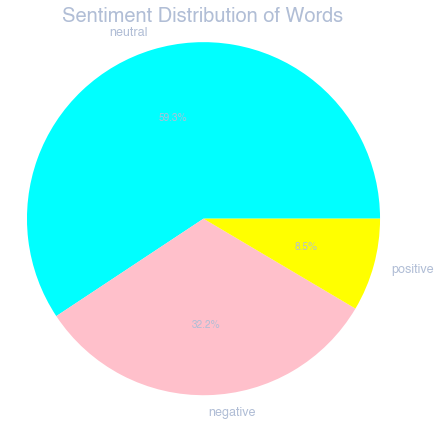

,index,sentiments
0,neutral,3556
1,negative,1930
2,positive,510


In [37]:
# Plot pie chart of Sentiment Distribution of words
emotion = {
        0: "neutral",
        1: "positive",
        -1: "negative"
}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]

words_df_pie = words["sentiments"].value_counts().reset_index()

plt.pie(words_df_pie["sentiments"],
        labels=words_df_pie["index"],
        radius=2,
        colors=colors,
        autopct="%1.1f%%")

plt.axis('equal')
plt.title("Sentiment Distribution of Words", fontsize=20)
plt.show()
words_df_pie

In [38]:
# Define a function to get the sentiment for the entire tweet
def getSentiments(row, sentiment_dict):

    total=0
    count=0
    test = row["clean_tweet"]
    for t in test:
        if words_cluster_dict.get(t):
            total+=int(sentiment_dict.get(t))
        count+=1 
        
    avg = total / count
    return -1 if (avg < -0.15) else 1 if (avg > 0.15) else 0

In [39]:
# Create a dictionary of the word and its cluster value
words_cluster_dict = dict(zip(words.words, words.cluster_value))

In [40]:
# Add sentiment column
target_tweets_df["sentiment"] = target_tweets_df.apply(getSentiments,
                                                         args=(words_cluster_dict,),
                                                         axis=1)

In [41]:
# Check the value counts of each sentiment
target_tweets_df["sentiment"].value_counts()

 0    9565
-1    4461
 1     365
Name: sentiment, dtype: int64

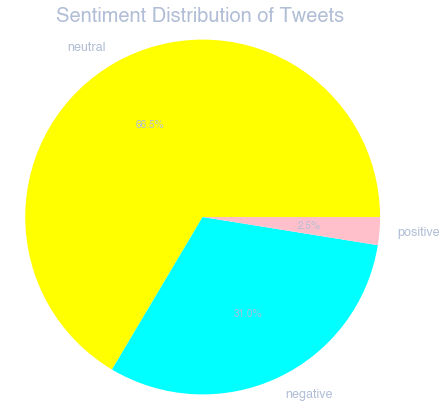

,index,sentiments_val
0,neutral,9565
1,negative,4461
2,positive,365


In [42]:
# Plotting pie chart of Sentiment Distribution of tweets
emotion = {
        0: "neutral",
        1: "positive",
        -1: "negative"
}

target_tweets_df["sentiments_val"] = target_tweets_df["sentiment"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["yellow","cyan","pink"]

tweets_df_pie = target_tweets_df["sentiments_val"].value_counts().reset_index()

plt.pie(tweets_df_pie["sentiments_val"],
        labels=tweets_df_pie["index"],
        radius=2,
        autopct="%1.1f%%",
        colors=colors)

plt.axis('equal')
plt.title("Sentiment Distribution of Tweets ", fontsize=20)
plt.show()
tweets_df_pie

In [43]:
# Save sentiment df
target_tweets_df.to_csv('data/transformed/test_sentiment.csv')

In [45]:
# Extract negative sentiments
negative_tweets_df = target_tweets_df[target_tweets_df["sentiment"]==-1]

In [46]:
# Inspect the cause of negative tweets
filter_cond = (target_tweets_df['year']==2022) & (target_tweets_df['month']==2)
list(negative_tweets_df['cleaned_tweet'][filter_cond])

['russia propaganda twitter attempt diminish everything ukraine fight spread lie mi',
 'do st petersburg dm would like blurb russian translation',
 'sadly take ukraine sacrificial lamb world wake mount unify assault',
 'starlink arrive pretty quickly ukraine slavaukraini ukrainerussiawar',
 'swear art form ukraine slavaukraini fckptn',
 'mr president strategic idea blow russian convoy still hav',
 "crisis avert ' russian ' influencer ' amp ' also insta yt tiktok etc originally post insta feb",
 'ukraine hit park social medium huge respect team behind',
 'joke foreign national fight go ukraine slavaukraini',
 'identify vulnerable russian site osint infosec ukraine netlas vulnerability',
 'sulayem need back ukraine support ukraine ban russian belorussian motorsport',
 'mess war always belong invader eg bush kuwait putin ukraine slavaukraini',
 'much love idea also need careful since russia easily exploit sneak']

In [47]:
# Trim for sample of negative tweets
list(negative_tweets_df["cleaned_tweet"][300:330])

['denazification ukraine easily achieve need russian withdraw russia',
 'scar ukrainian child picture lead metro system shelter russian shell',
 'block multiple russian financial institution payment network compliance western',
 'break hospital kharkov bankruptputin save ukraine protect world standwithukriane',
 'delete lot previous tweet opinion current situation ukraine report',
 'mbt law trust nlaw stopputinnow stopputinswar stoprussianaggression stopwarinukraine slavaukraini',
 'regular ukrainian civilian stop russian convoy sing national anthem slavaukraini',
 'en sanction belarus slavaukraini ukraine',
 'russian convoy destroy near sumy ukraine russia ukrainerussiawar ukraineinvasion',
 'color destiny bleed blue yellow ukraine prevail',
 'may major general st javelin protect slavaukraini standingwithukraine',
 'algo btc send ukraine slavaukraini algofam nftsnotbombs btc',
 'first unit foreign volunteer belarusian bankruptputin save ukraine protect world',
 'russian agent personal

## Visualization

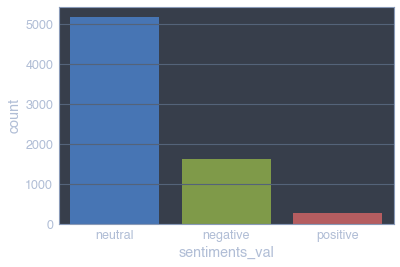

In [48]:
# Inspect keyword sentiment
selections = ['slava', 'zelensky', 'volodimir']

keyword_sent_df = target_tweets_df[(target_tweets_df["cleaned_tweet"].str.contains('|'.join(selections)))]
sns.countplot(x=keyword_sent_df["sentiments_val"]);

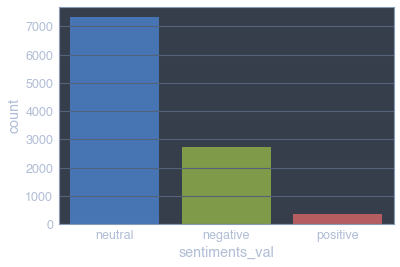

In [49]:
# Inspect ukraine sentiment
selections = ["ukraine"]

keyword_sent_df = target_tweets_df[(target_tweets_df["cleaned_tweet"].str.contains('|'.join(selections)))]
sns.countplot(x = keyword_sent_df["sentiments_val"]);

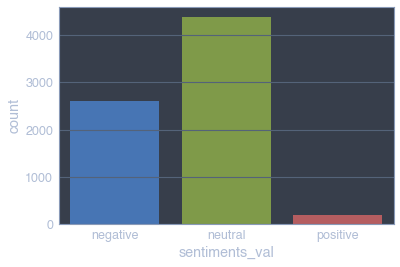

In [50]:
# Inspect russia sentiment
selections = ["russia"]

keyword_sent_df = target_tweets_df[(target_tweets_df["cleaned_tweet"].str.contains('|'.join(selections)))]
sns.countplot(x=keyword_sent_df["sentiments_val"]);

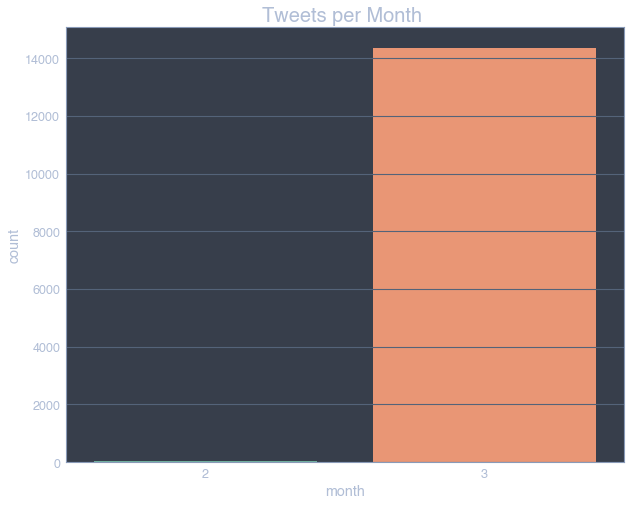

In [51]:
# Tweet counts

plt.subplots(figsize = (10,8))

chart = sns.countplot(x="month", data=target_tweets_df, palette="Set2");
chart.set_xticklabels(chart.get_xticklabels())

plt.title("Tweets per Month ", fontsize=20)
plt.show()

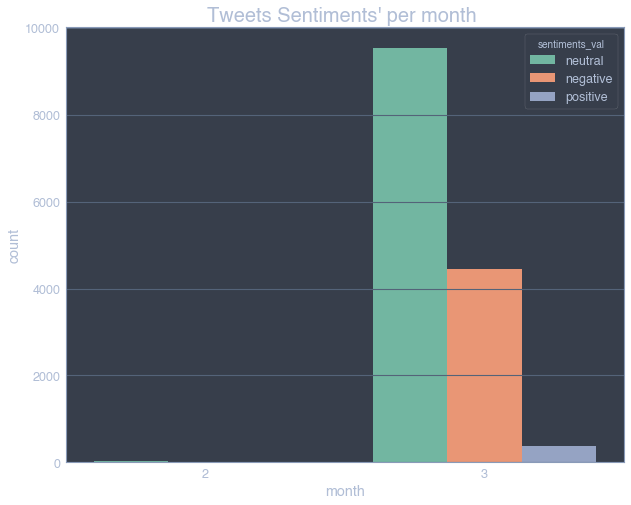

In [52]:
# Tweet sentiments for each month
plt.subplots(figsize = (10,8))

chart = sns.countplot(x="month", data=target_tweets_df, palette="Set2", hue="sentiments_val");
chart.set_xticklabels(chart.get_xticklabels())

plt.title("Tweets Sentiments' per month ", fontsize=20)
plt.show();

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7457 (\N{LATIN LETTER SMALL CAPITAL W}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7431 (\N{LATIN LETTER SMALL CAPITAL E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7458 (\N{LATIN LETTER SMALL CAPITAL Z}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127987 (\N{WAVING WHITE FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.

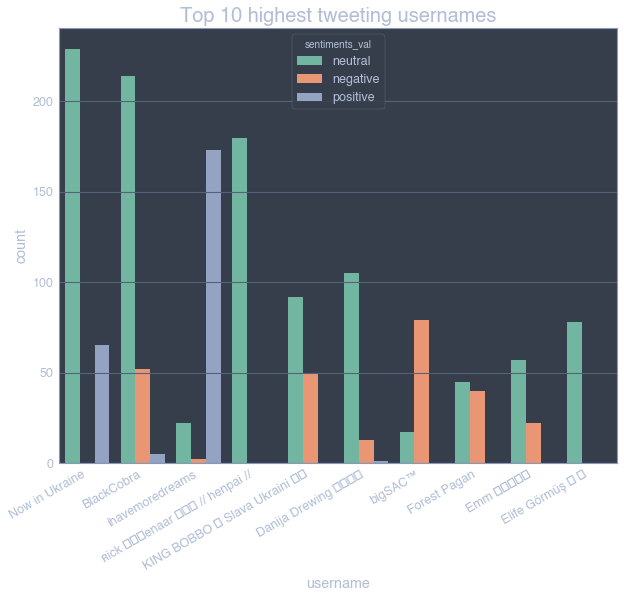

In [53]:
# Top 10 highest tweeting usernames
plt.subplots(figsize = (10,8))

plt.title("Top 10 highest tweeting usernames", fontsize=20)

chart = sns.countplot(x="username",
                    hue="sentiments_val",
                    data=target_tweets_df,
                    palette="Set2",
                    order= target_tweets_df["username"].value_counts().iloc[:10].index);

chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=30, 
                      horizontalalignment='right');

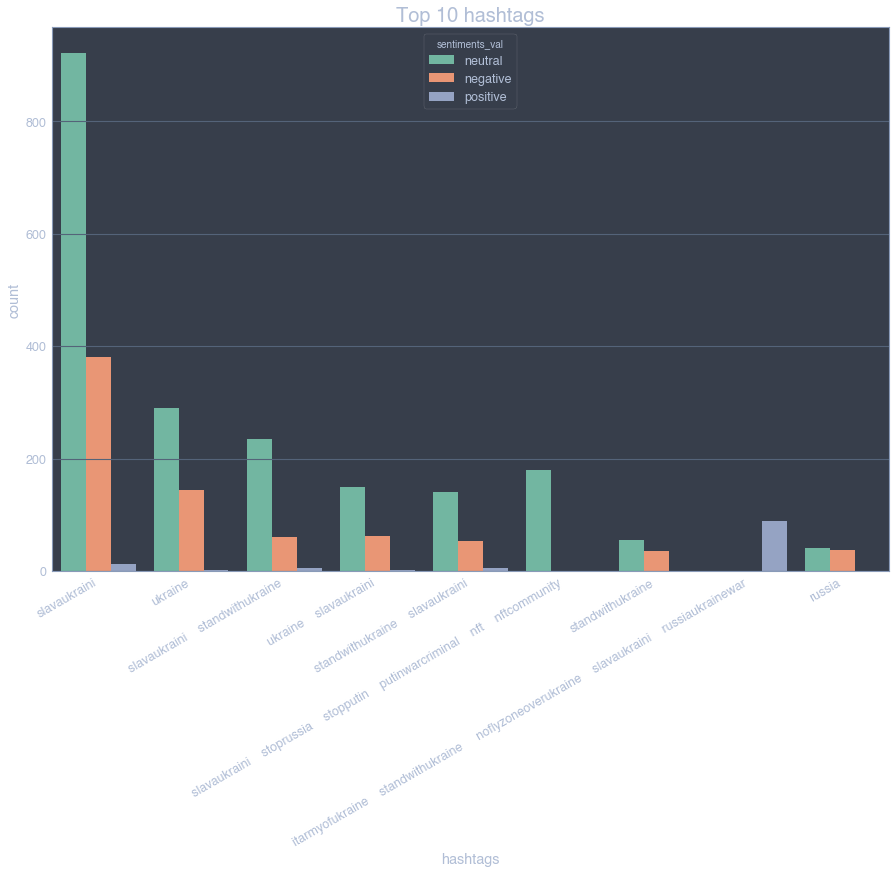

In [54]:
# Top 10 most used hashtags
plt.subplots(figsize = (15,10))
plt.title("Top 10 hashtags", fontsize=20)

chart=sns.countplot(x="hashtags",
                    hue="sentiments_val",
                    data=target_tweets_df,
                    palette="Set2",
                    order=target_tweets_df["hashtags"].value_counts().iloc[1:10].index);

chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=30, 
                      horizontalalignment='right');

### WordCloud

In [55]:
def generateWordcloud(text):
    words=' '.join([words for words in text])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

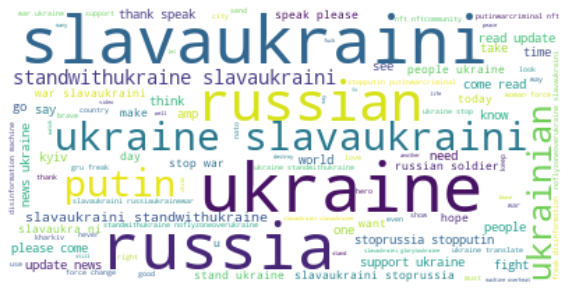

In [56]:
# Wordcloud for all tweets
generateWordcloud(target_tweets_df["cleaned_tweet"].values)

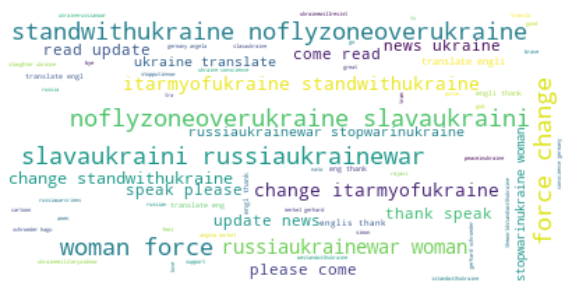

In [57]:
# Wordcloud for positive tweets
generateWordcloud(target_tweets_df[target_tweets_df["sentiment"]==1]["cleaned_tweet"].values)

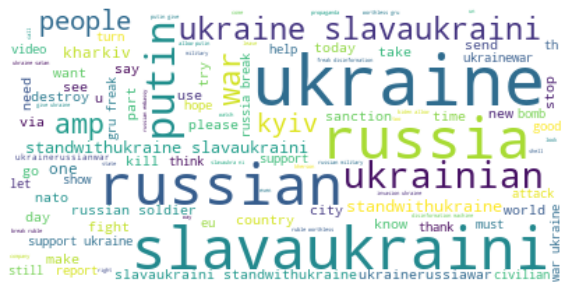

In [58]:
# Wordcloud for negative tweets
generateWordcloud(target_tweets_df[target_tweets_df["sentiment"]==-1]["cleaned_tweet"].values)

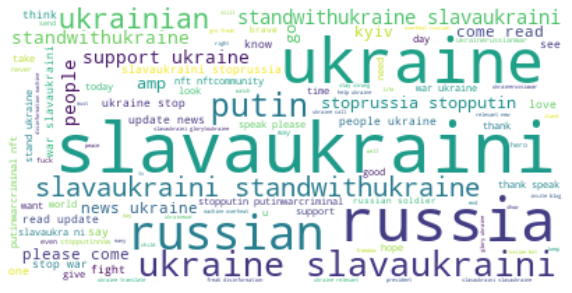

In [59]:
# Wordcloud for neutral tweets
generateWordcloud(target_tweets_df[target_tweets_df["sentiment"]==0]["cleaned_tweet"].values)

## Prediction modelling

In [60]:
target_tweets_df.head()

,date,username,description,location,tweet,hashtags,clean_tweet,cleaned_tweet,month,year,sentiment,sentiments_val
0,2022-02-28 23:55:31,Rob Smith 🇨🇦 🇺🇦,"Proud Canadian 🇨🇦, ❤️ baseball ⚾️, ❤️ history,...","Ontario, Canada",@kiraincongress Photos of rally in support of ...,nan,"[photo, rally, support, ukraine, toronto, cana...",photo rally support ukraine toronto canada sun...,2,2022,0,neutral
1,2022-02-28 23:55:21,Frags,ay yo video games\nMarried To My Best Friend @...,Chicago,#Russia propaganda on #Twitter attempting to d...,russia twitter ukraine,"[russia, propaganda, twitter, attempt, diminis...",russia propaganda twitter attempt diminish eve...,2,2022,-1,negative
4,2022-02-28 23:54:28,Sydfish 🇺🇦🇺🇦🇺🇦🇺🇦,Soccer mom with a punk rock heart!!!!🛑NO LISTS...,"California, USA",I’ve done more than 100 in St. Petersburg. \n\...,nan,"[do, st, petersburg, dm, would, like, blurb, r...",do st petersburg dm would like blurb russian t...,2,2022,-1,negative
7,2022-02-28 23:54:06,Jinx Spidox ➡️ Gdakon,"Railway Electrician, Lanky Wuff, Skoda driver,...","Glasgow, Scotland",#SlavaUkraini good night #Ukraine keep up the ...,slavaukraini ukraine,"[slavaukraini, good, night, ukraine, keep, goo...",slavaukraini good night ukraine keep good figh...,2,2022,0,neutral
8,2022-02-28 23:53:58,Jackie Blue 🇺🇸 🇨🇦 🇺🇦 🌻,"Well, now on to the next emergency. (And more ...",🇺🇸 Wrong Side of the 49th,@anagin40 @NATO It sadly took Ukraine being a ...,nan,"[sadly, take, ukraine, sacrificial, lamb, worl...",sadly take ukraine sacrificial lamb world wake...,2,2022,-1,negative


In [61]:
# Convert each sentiment to df (no need to worry about memory crash, small dataset)
pos_df = target_tweets_df[target_tweets_df["sentiments_val"]=="positive"]
neg_df = target_tweets_df[target_tweets_df["sentiments_val"]=="negative"]
neu_df = target_tweets_df[target_tweets_df["sentiments_val"]=="neutral"]

In [62]:
# Combine all sentiments in one df
sentiments_df_list = [pos_df, neg_df, neu_df] 
agg_sentiment_df = pd.concat(sentiments_df_list)

In [63]:
# Split the data to training, testing, and validation data 
train_test_df, valid_df = train_test_split(agg_sentiment_df, test_size=0.2, random_state=10)

In [64]:
X = train_test_df['cleaned_tweet']
y = train_test_df['sentiment']

# Split the dataset set int0 training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Vectorization

In [65]:
# Instantiate TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=3,
                             sublinear_tf=True,
#                              encoding="latin-1",
                             ngram_range=(1,2),
                             stop_words='english')

In [66]:
# Fit vectorizer
X_train_tf = vectorizer.fit_transform(X_train.reset_index()["cleaned_tweet"]).toarray()
X_test_tf = vectorizer.transform(X_test.reset_index()["cleaned_tweet"]).toarray()

In [67]:
feature_names = vectorizer.get_feature_names_out() 

### Build models

In [68]:
# Evaluate various models

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    XGBClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, 
                                 X_train_tf, 
                                 y_train, 
                                 scoring='accuracy', 
                                 cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:07:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:09:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:12:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:14:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:17:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [69]:
# Aggregate validation scorese
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

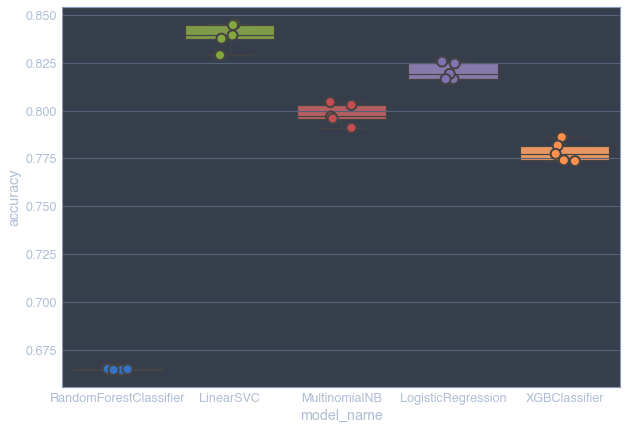

In [70]:
# Plot model performances
plt.subplots(figsize = (10,7))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', 
              y='accuracy', 
              data=cv_df, 
              size=10,
              jitter=True, 
              edgecolor="gray", 
              linewidth=2)

plt.show()

In [71]:
# Check mean accuracy for each model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.839179
LogisticRegression        0.820502
MultinomialNB             0.798242
RandomForestClassifier    0.664676
XGBClassifier             0.778586
Name: accuracy, dtype: float64

In [72]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.665038
1,RandomForestClassifier,1,0.664495
2,RandomForestClassifier,2,0.664495
3,RandomForestClassifier,3,0.664495
4,RandomForestClassifier,4,0.664856
5,LinearSVC,0,0.828990
6,LinearSVC,1,0.845277
7,LinearSVC,2,0.844734
8,LinearSVC,3,0.839305
9,LinearSVC,4,0.837588


## LinearSVC

In [60]:
# Create a dict of Sentiment_val: sentiments to use with the confusion matrix
sentiment_id_df = agg_sentiment_df[['sentiments_val', 'sentiment']].drop_duplicates().sort_values('sentiment')
sentiment_to_id = dict(sentiment_id_df.values)

In [61]:
# Instantiate the model
linearSVC = LinearSVC(random_state=0)

In [62]:
# Fit the model
linearSVC.fit(X_train_tf, y_train)

LinearSVC(random_state=0)

In [63]:
# Predict
svc_y_pred = linearSVC.predict(X_test_tf)

In [ ]:
# Plot confusion matrix to evaluate the model results
svc_conf_mat = confusion_matrix(y_test, svc_y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(svc_conf_mat, 
            annot=True, 
            fmt='d',
            xticklabels=sentiment_id_df.sentiments_val.values, 
            yticklabels=sentiment_id_df.sentiment.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Get classification report
print(metrics.classification_report(y_test, svc_y_pred))

In [ ]:
# Use score method to get accuracy of model
svc_score = linearSVC.score(X_test_tf, y_test)
print(svc_score)

In [ ]:
# Feature importance

def plotCoefficients(classification, feature_names, top_features=20):
    size = len(feature_names)
    coef_neg = classification.coef_[-1][:size]
    coef_pos = classification.coef_[1][:size]
    top_positive_coefficients = np.argsort(coef_pos[coef_pos>0])[-top_features:]
    top_negative_coefficients = np.argsort(coef_pos[coef_neg<0])[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    coef=np.hstack([coef_neg,coef_pos])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    title="Positive and Negative Labels"
    plt.title(title)
    plt.show()

In [ ]:
coefs_with_fns = sorted(zip(linearSVC.coef_[0], feature_names)) 
df_feat = pd.DataFrame(coefs_with_fns)
df_feat.columns = 'coefficient','word'
df_feat.sort_values(by='coefficient')

plotCoefficients(linearSVC, feature_names)

In [ ]:
# Save linearSVC model
dump(linearSVC, '../models/linearSVC.joblib')

## MultinomialNB Model

In [ ]:
# Instantiate the model
multiNB = MultinomialNB()

In [ ]:
# Fit the model
multiNB.fit(X_train_tf, y_train)

In [ ]:
# predict
nb_y_pred = multiNB.predict(X_test_tf)

In [ ]:
# Plot confusion matrix to evaluate the model results
conf_mat = confusion_matrix(y_test, nb_y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d',
            xticklabels=sentiment_id_df.sentiments_val.values, 
            yticklabels=sentiment_id_df.sentiment.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Print classification report
print(metrics.classification_report(y_test, nb_y_pred))

In [ ]:
# Use score method to get accuracy of model
nb_score = multiNB.score(X_test_tf, y_test)
print(nb_score)

In [ ]:
# Save linearSVC model
dump(multiNB, '../models/multinomialNB.joblib')

## Comparison: LinearSVC vs. MultinomialNB

In [ ]:
# Format validation set
valid_df = valid_df.reset_index()
valid_df.tail()

In [ ]:
# Create new df contains the sentiment and its encoded value, and create two dictionaries
sentiment_id_df = target_tweets_df[['sentiments_val', 'sentiment']].drop_duplicates().sort_values('sentiment')
sentiment_to_id = dict(sentiment_id_df.values)

id_to_sentiment = dict(sentiment_id_df[['sentiment', 'sentiments_val']].values)

print("sentiment_to_id: ",sentiment_to_id)
print("id_to_sentiment: ",id_to_sentiment)

In [ ]:
# Select "random" tweet
tweet = target_tweets_df["tweet"][202]
tweet

In [ ]:
# test the data
clean = vectorizer.transform([tweet]) # apply TFIDF
pred = linearSVC.predict(clean) # predict the tweet using out model
pred = id_to_sentiment[pred[0]]
print(pred)

## Validation

In [ ]:
# Define our X and y
X_val = valid_df['cleaned_text']
y_val = valid_df['sentiment']

In [ ]:
# Vectorize the model
vectorizer = TfidfVectorizer(min_df=3,
                             sublinear_tf=True,
#                              encoding="latin-1", 
                             ngram_range=(1,2),
                             stop_words='english')

In [ ]:
# Fit vectors
X_val_tf = vectorizer.fit_transform(X_val.reset_index()['cleaned_text']).toarray()

In [ ]:
# Fit multinomialNB
multiNB.fit(X_val_tf, y_val)

In [ ]:
# Plot confusion matrix to evaluate the model results
conf_mat = confusion_matrix(y_val, multiNB.predict(X_val_tf))

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d',
            cmap='viridis',
            xticklabels=sentiment_id_df.sentiments_val.values, 
            yticklabels=sentiment_id_df.sentiment.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Print classification report
print(metrics.classification_report(y_val, multiNB.predict(X_val_tf)))